PART B: REGRESSION (50 marks)

This part of the assignment is to be completed individually.
Background
This is a dataset to predict the housing price in US based on various factors such as
city, house area, No. of bedrooms and toilets, renovation status, etc.
Dataset
You are going to use the dataset: housing_dataset.csv.
Tasks
1. Write the code to solve the prediction task. You should use scikit-learn for
the machine learning models (no 3rd party libraries).
2. In the Jupyter notebook, write your report detailing your implementation,
your experiments and analysis (along with your python code and
comments). In particular, we'd like to know:
 How is your prediction task defined? And what is the meaning of the
output variable?
 How do you represent your data as features?
 Did you process the features in any way?
 How did you select which learning algorithms to use?
 Did you try to tune the hyperparameters of the learning algorithm, and in
that case how?
 How do you evaluate the quality of your system?
 How well does your system compare to a dummy baseline?
 Can you say anything about the errors that the system makes?
 Is it possible to say something about which features the model considers
important?
3. Create a set of slides with the highlights of your Jupyter notebook report.
Explain the entire machine learning process you went through, data
exploration, data cleaning, feature engineering, model building and
evaluation, and model improvement. Write your conclusions.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.dummy import DummyRegressor
from tqdm import tqdm
import random

In [19]:
data = pd.read_csv('housing_dataset.csv')

In [20]:
data

,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000
1,1,Denver,896.0,4,4,4,furnished,1225000
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,3,Seattle,750.0,4,2,2,furnished,1221500
4,4,New York,742.0,4,1,2,furnished,1141000
...,...,...,...,...,...,...,...,...
540,540,Seattle,300.0,2,1,1,unfurnished,182000
541,541,New York,240.0,3,1,1,semi-furnished,176715
542,542,Boston,362.0,2,1,1,unfurnished,175000
543,543,Seattle,291.0,3,1,1,furnished,175000


In [21]:
data['No. of Bedrooms'].unique()

array([4, 3, 5, 2, 6, 1], dtype=int64)

# EDA

    We can do some basic exploratory data analysis to gain further insight on the data

In [22]:
#check for null values

for i in data.columns:
    print(f"{i}, null values: {data[i].isnull().sum()}")


House ID, null values: 0
City, null values: 0
House Area (sqm), null values: 0
No. of Bedrooms, null values: 0
No. of Toilets, null values: 0
Stories, null values: 0
Renovation Status, null values: 0
Price ($), null values: 0


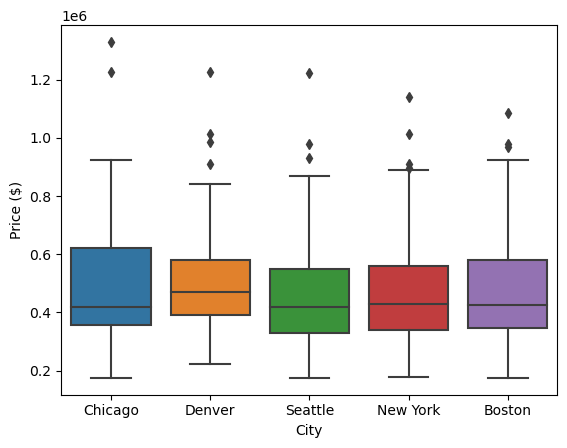

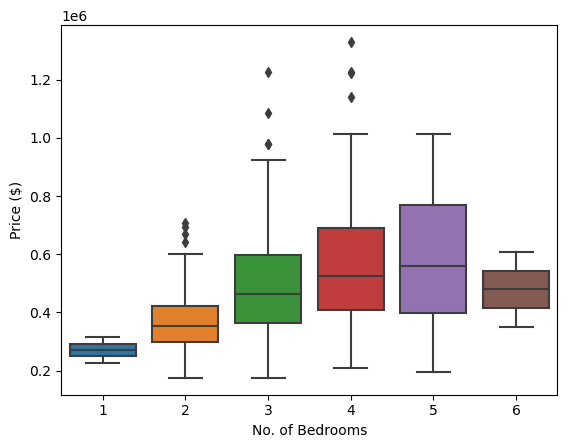

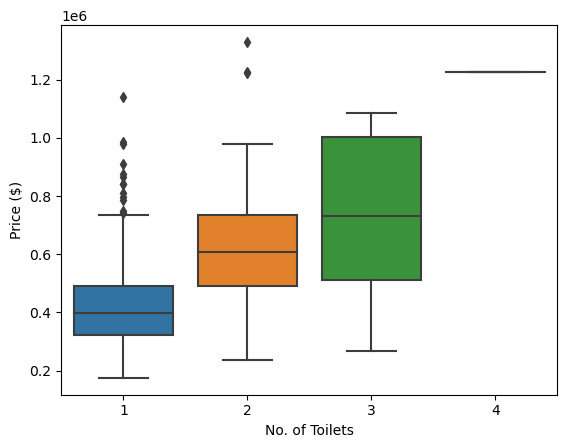

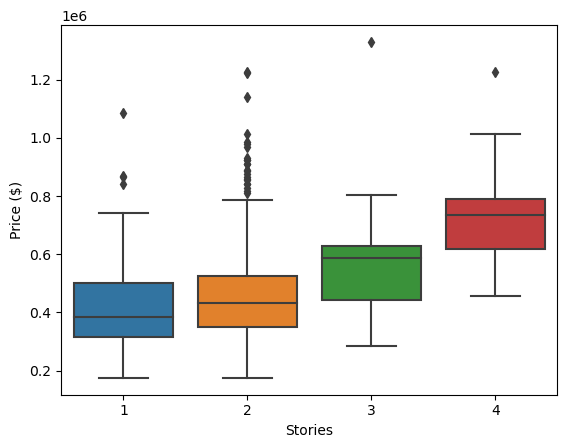

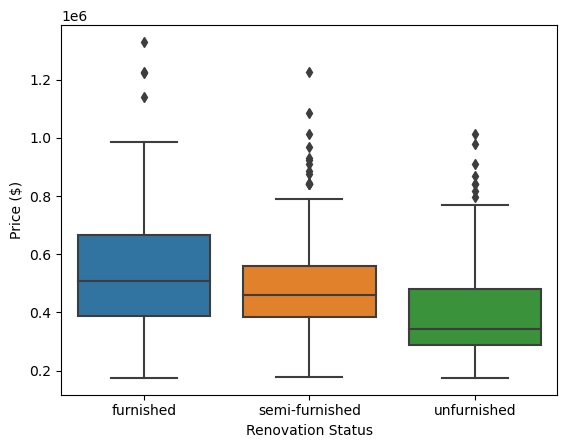

In [23]:
#there are no null values in the dataset, we can proceed with the rest of the analysis

#find the distribution and corelation between the features and price

features = ['City',  'No. of Bedrooms', 'No. of Toilets', 'Stories', 'Renovation Status']
target = ['Price ($)']

for i in features:
    sns.boxplot(x=data[i], y=data[target[0]])
    plt.show()

## Normalizing data

Some of the Regression models assume normal distribution in the data for eg. Linear Regression, Ridge Regression, Ridge Regression, ElasticNet Regression, SVR

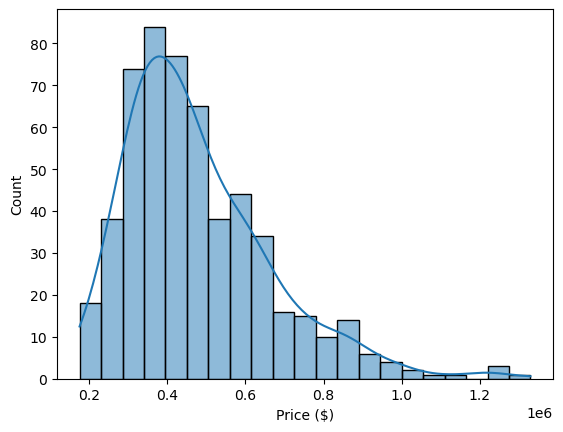

In [24]:
#from the above plots we can see that there are outliers in the data, however outliers are not that significant in this case as we are performing regression,
#however it is still good to keep these in mind

#now we will find the distribution of the target variable

sns.histplot(data[target[0]], kde = True)
plt.show()

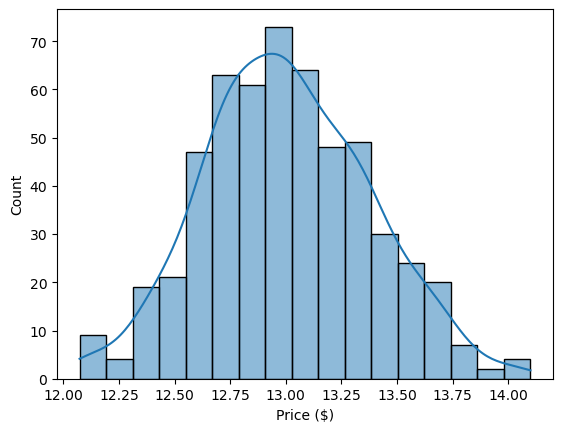

In [25]:
#from the previous plot we can note that the target variable is skewed to the left, meaning that the data is not normally distributed
#this is usually not much of a problem however some models might face some issues as they assume that the data is normally distributed
#we will try to fix this by applying a log transformation to the target variable

data[target[0]] = np.log(data[target[0]])
sns.histplot(data[target[0]], kde = True)
plt.show()

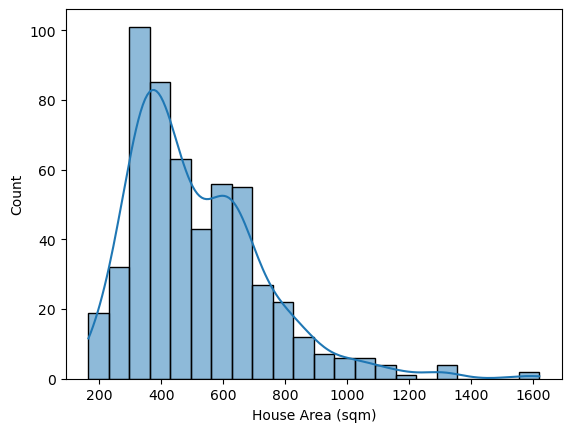

In [26]:
#seeing that the target variable is not normally distributed, i wonder if the features are normally distributed
#namely the numerical features which include housing area

numerical_features = ['House Area (sqm)']

for i in numerical_features:
    sns.histplot(data[i], kde = True)
    plt.show()

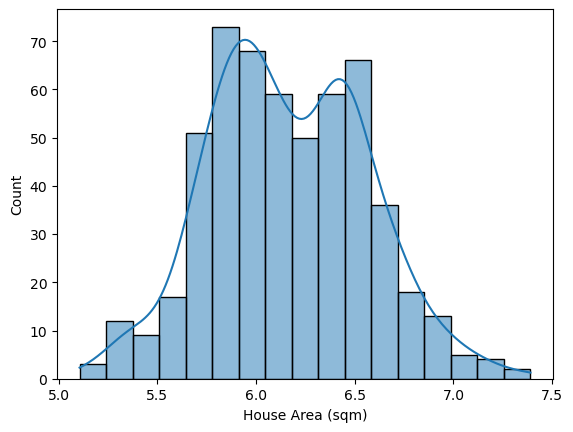

In [27]:
#the numerical features are also not normally distributed(left skew), we will apply a log transformation to these features as well

for i in numerical_features:
    data[i] = np.log(data[i])
    sns.histplot(data[i], kde = True)
    plt.show()

## take aways

Somethings we can note from the previous data visualization

    most cities have similar medians

    as expected, stories, bedrooms and toilets generally have a positive relationship with price (exception being 6 rooms)
    however due to this exception, we can consider ordinal encoding for rooms in order to re order the sequence of rooms (6 less than 4th, push 4 to 5th and 5 to 6th)

# Preprocessing

- How do you represent your data as features?
- Did you process the features in any way?

In [28]:
#drop ID as it is irrelevant and misleading
data.drop(['House ID'], axis=1, inplace=True)

scalar = StandardScaler()

data[['House Area (sqm)']] = scalar.fit_transform(data[['House Area (sqm)']])

ordinal_encoder = OrdinalEncoder(categories=[['furnished', 'semi-furnished', 'unfurnished']])
data[['Renovation Status']] = ordinal_encoder.fit_transform(data[['Renovation Status']])

ordinal_encoder = OrdinalEncoder(categories=[['1', '2', '3','6', '4', '5']])
data[['No. of Bedrooms']] = data[['No. of Bedrooms']].astype(str)
data[['No. of Bedrooms']] = ordinal_encoder.fit_transform(data[['No. of Bedrooms']])

ordinal_encoder = OrdinalEncoder(categories=[['1', '2', '3','4', '5']])
data[['No. of Toilets']] = data[['No. of Toilets']].astype(str)
data[['No. of Toilets']] = ordinal_encoder.fit_transform(data[['No. of Toilets']])

ordinal_encoder = OrdinalEncoder(categories=[['1', '2', '3','4']])
data[['Stories']] = data[['Stories']].astype(str)
data[['Stories']] = ordinal_encoder.fit_transform(data[['Stories']])

data = pd.get_dummies(data, columns=['City'], prefix=['City'])
data

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($),City_Boston,City_Chicago,City_Denver,City_New York,City_Seattle
0,1.119319,4.0,1.0,2.0,0.0,14.100690,0,1,0,0,0
1,1.593264,4.0,3.0,3.0,0.0,14.018451,0,0,1,0,0
2,1.859165,2.0,1.0,1.0,1.0,14.018451,0,1,0,0,0
3,1.146269,4.0,1.0,1.0,0.0,14.015590,0,0,0,0,1
4,1.119319,4.0,0.0,1.0,0.0,13.947416,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
540,-1.156444,1.0,0.0,0.0,2.0,12.111762,0,0,0,0,1
541,-1.717222,2.0,0.0,0.0,1.0,12.082294,0,0,0,1,0
542,-0.684333,1.0,0.0,0.0,2.0,12.072541,1,0,0,0,0
543,-1.232991,2.0,0.0,0.0,0.0,12.072541,0,0,0,0,1


In [29]:
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'K-Nearest Neighbors Regression': KNeighborsRegressor(),
    'Dummy Regressor': DummyRegressor()
}

features = ['City_Boston', 'City_Chicago', 'City_Seattle', 'City_New York',  'City_Denver',  'No. of Bedrooms', 'No. of Toilets', 'Stories', 'Renovation Status', 'House Area (sqm)']


X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
#train the models to get a rough idea of the performance of the models
lst = []

for model_name, model in regression_models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred), squared=False)
    mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
    mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
    r2 = r2_score(np.exp(y_test), np.exp(y_pred))
    
    # Append the results to the list
    lst.append([model_name, rmse, mse, mae, r2])

# Create a DataFrame from the list
baseresults = pd.DataFrame(lst, columns=['Model', 'RMSE', 'MSE', 'MAE', 'R2'])
baseresults

,Model,RMSE,MSE,MAE,R2
0,Linear Regression,147017.341192,2.161410e+10,99367.889600,0.526764
1,Ridge Regression,147067.828860,2.162895e+10,99379.392460,0.526438
2,Lasso Regression,219320.456912,4.810146e+10,158084.429241,-0.053172
3,ElasticNet Regression,219320.456912,4.810146e+10,158084.429241,-0.053172
4,Support Vector Regression,152948.722654,2.339331e+10,97386.410650,0.487808
5,Decision Tree Regression,177359.936498,3.145655e+10,123514.504864,0.311265
6,Random Forest Regression,156347.567338,2.444456e+10,103534.456218,0.464791
7,K-Nearest Neighbors Regression,169603.383291,2.876531e+10,105912.897474,0.370189
8,Dummy Regressor,219320.456912,4.810146e+10,158084.429241,-0.053172


## Evaluation metrics

- How do you evaluate the quality of your system?

R-squared (R2) score:

        R2 score measures the proportion of the variance in the target variable (housing price) that can be explained by the independent variables (features) in the model. It indicates how well the model fits the data and captures the variability in the target variable.

        Using R2 score as a grading metric is beneficial because it provides an overall measure of the model's goodness of fit. A higher R2 score (closer to 1) suggests that the model explains a larger proportion of the variance in the housing prices, indicating a better fit. Conversely, a lower R2 score (closer to 0) implies that the model does not capture much of the variance in the target variable.

        Overall, R2 score will be used as it is easy to read (0 - 1 scale, anything below 0 means garbage) and because it allows you to see how well a model captures the variability/variance of the data

Root mean squared error(RMSE):

        RMSE measures the average magnitude of the prediction errors in the same units as the target variable (housing price). It calculates the square root of the average of the squared differences between the predicted and actual housing prices.

        Overall RMSE is used to pinpoint more on the errors that the model makes which works well in harmony with R2 scoring

By considering both R2 score and RMSE, you gain a comprehensive understanding of the model's performance. R2 score helps assess the overall fit and explained variance, while RMSE focuses on the average prediction error. These metrics together provide insights into the model's accuracy, precision, and ability to capture the variation in housing prices, which will be enough for my analysis and will allow me to remove the other metrics to make the evaluation easier to interpret.

In [31]:
baseresults = baseresults[['Model', 'RMSE', 'R2']]
baseresults.sort_values(by='RMSE', ascending=True)



,Model,RMSE,R2
0,Linear Regression,147017.341192,0.526764
1,Ridge Regression,147067.828860,0.526438
4,Support Vector Regression,152948.722654,0.487808
6,Random Forest Regression,156347.567338,0.464791
7,K-Nearest Neighbors Regression,169603.383291,0.370189
5,Decision Tree Regression,177359.936498,0.311265
2,Lasso Regression,219320.456912,-0.053172
3,ElasticNet Regression,219320.456912,-0.053172
8,Dummy Regressor,219320.456912,-0.053172


## Feature importance 

# Grid Search

As oversampling is not needed for regression, i will just be using a normal grid search instead of the pipeline one

- Did you try to tune the hyperparameters of the learning algorithm, and in
that case how?

In [32]:
def grid_search(model, param_grid, X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {
        'r2': make_scorer(r2_score)
    }

    # Define the grid search
    grid = GridSearchCV(model,
                        param_grid=param_grid,
                        cv= kf,
                        scoring=scoring,
                        n_jobs = -1,
                        verbose=1)

    # Fit the grid search to the data
    grid_result = grid.fit(X_train, y_train)
    best_params = grid_result.best_params_
    r2 = r2_score(y_test, np.exp(grid_result.best_estimator_.predict(X_test)))
    rmse = mean_squared_error(y_test, np.exp(grid_result.best_estimator_.predict(X_test)), squared=False)

    return best_params, rmse, r2


In [33]:
grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'param_grid': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'positive': [False, True],
        }
    },
    'Ridge Regression': {
        'model': Ridge(),
        'param_grid': {
            'alpha': [0.1, 1.0, 10.0],  # Regularization strength
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],  # Solver algorithm
            'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
            'tol': [1e-3, 1e-4, 1e-5],  # Tolerance for stopping criteria
            'random_state': [42]  # Seed for random number generator
        }
    },
    'Lasso Regression': {
        'model': Lasso(),
        'param_grid': {
            'alpha': [0.1, 1.0, 10.0],  # Regularization strength
            'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
            'tol': [1e-3, 1e-4, 1e-5],  # Tolerance for stopping criteria
            'random_state': [42]  # Seed for random number generator
        }
    },
    'ElasticNet Regression': {
        'model': ElasticNet(),
        'param_grid': {
            'alpha': [0.1, 1.0, 10.0],  # Regularization strength
            'l1_ratio': [0.25, 0.5, 0.75],  # Mixing parameter between L1 and L2 penalties
            'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
            'tol': [1e-3, 1e-4, 1e-5],  # Tolerance for stopping criteria
            'random_state': [42]  # Seed for random number generator
        }
    },
    'Support Vector Regression': {
        'model': SVR(),
        'param_grid': {
            'kernel': ['linear', 'rbf'],  # Kernel type
            'C': [0.1, 1.0, 10.0],  # Penalty parameter C of the error term
            'epsilon': [0.1, 0.01, 0.001],  # Epsilon in the epsilon-SVR model
            'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf' kernel
            'shrinking': [True, False],  # Whether to use the shrinking heuristic
            'tol': [1e-3, 1e-4, 1e-5]  # Tolerance for stopping criteria
        }
    },
    'Decision Tree Regression': {
        'model': DecisionTreeRegressor(),
        'param_grid': {
            'criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
            'splitter': ['best', 'random'],
            'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_split': [2, 4, 6, 8, 10],
            'min_samples_leaf': [1, 2, 3, 4, 5]
        }
    },
    'K Neighbors Regression': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 20, 30, 40, 50],
            'p': [1, 2]
        }
    },
    'Random Forest Regression': {
        'model': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
            'max_depth': [2, 4, 6, 8],
            'min_samples_split': [2, 4, 6, 8, 10],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    }
}

In [34]:
for i in tqdm(grids):
    best_params, cv_results, rmse, r2 = grid_search(grids[i]['model'], grids[i]['param_grid'], X_train, y_train, X_test, y_test)
    grids[i]['best_params'] = best_params
    grids[i]['cv_results'] = cv_results
    grids[i]['rmse'] = rmse
    grids[i]['r2'] = r2
    

  0%|          | 0/8 [00:00<?, ?it/s]


ValueError: For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit an estimator with the best parameter setting on the whole data and make the best_* attributes available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.

In [ ]:
gridsearched = pd.DataFrame(grids)
gridsearched = gridsearched.T

gridsearched = gridsearched[['best_params', 'rmse', 'r2']]
gridsearched['model'] = gridsearched.index
gridsearched = gridsearched.reset_index(drop=True)
gridsearched = gridsearched[['model', 'best_params', 'rmse', 'r2']]

In [ ]:
gridsearched.sort_values(by='r2', ascending=False)
gridsearched.columns = ['Model', 'Best Parameters', 'RMSE', 'R2']

In [ ]:
baseresults['Model'] = baseresults['Model'].str.replace('Regression', 'Base')

C:\Users\cairu\AppData\Local\Temp\ipykernel_16948\209157449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseresults['Model'] = baseresults['Model'].str.replace('Regression', 'Base')


In [ ]:
compare1 = pd.concat([gridsearched, baseresults], axis=0, ignore_index=True)

In [ ]:
compare1.sort_values(by='R2', ascending=False)[['Model', 'R2', 'RMSE']]

,Model,R2,RMSE
3,ElasticNet Regression,0.461261,134761.570308
1,Ridge Regression,0.454909,135553.644421
4,Support Vector Regression,0.450311,136124.18513
9,Ridge Base,0.44628,136622.383967
7,Random Forest Regression,0.445708,136692.947315
0,Linear Regression,0.445165,136759.839282
12,Support Vector Base,0.436709,137798.074888
8,Linear Base,0.433074,138241.998402
5,Decision Tree Regression,0.410276,140994.150242
6,K Neighbors Regression,0.398531,142391.217348


# Custom Hyperparameter tuning
  
- Did you try to tune the hyperparameters of the learning algorithm, and in
that case how?

As you can see from the above output, overall there is no obvious increase or decrease in overall performance, different models seem to be affected differently by the gridsearch(some increase in R2 while others decrease)

Because of this, i will be trying a similar hyperparameter tuning method from the classification part of the assignment. However this time i will be tuning multiple models instead as many of the lower base performance models (ElasticNet ,DTC, Lasso) seem to have a huge increase in perofrmance after tuning

In [ ]:
tunable = {
    'kneighborsregression': {
        'classifier': KNeighborsRegressor(),
        'tunable': {
            'n_neighbors': (1, 20, "int"),  # Number of neighbors to consider
            'weights': (["uniform", "distance"], "str"),  # Weight function used in prediction
            'algorithm': (["auto", "ball_tree", "kd_tree", "brute"], "str"),  # Algorithm used to compute nearest neighbors
            'leaf_size': (10, 50, "int"),  # Leaf size for tree-based algorithms
            'p': (1, 2, "int")  # Power parameter for the Minkowski distance metric
        }
    },
    
    'linear': {
        'classifier': LinearRegression(),
        'tunable': {
            'fit_intercept': (True, False, "bool"),  # Whether to calculate the intercept for this model
            'copy_X': (True, False, "bool"),  # Whether to make a copy of X before fitting the model
        }
    },

    'ridge': {
        'classifier': Ridge(random_state=42),
        'tunable': {
            'alpha': (0.01, 1.0, "float"),  # Regularization strength
            'fit_intercept': (True, False, "bool"),  # Whether to calculate the intercept for this model
            'solver': (["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"], "str"),  # Solver algorithm
            'copy_X': (True, False, "bool"),  # Whether to make a copy of X before fitting the model
            'max_iter': (1000, 5000, "int"),  # Maximum number of iterations for conjugate gradient solver
            'tol': (0.001, 0.01, "float"),  # Precision of the solution
        }
    },

    'lasso': {
        'classifier': Lasso(random_state=42),
        'tunable': {
            'alpha': (0.01, 1.0, "float"),  # Regularization strength
            'fit_intercept': (True, False, "bool"),  # Whether to calculate the intercept for this model
            'selection': (["cyclic", "random"], "str"),  # Method used to select features during each iteration
            'tol': (0.001, 0.01, "float"),  # Precision of the solution
            'warm_start': (True, False, "bool"),  # When set to True, reuse the solution of the previous call to fit as initialization
            'positive' : (True, False, "bool")  # When set to True, forces the coefficients to be positive
        }
    },

    'elasticnet': {
        'classifier': ElasticNet(random_state=42),
        'tunable': {
            "alpha": (0, 100, "float"),
            "l1_ratio": (0, 1, "float"),
            "max_iter": (100, 10000, "int"),
            "tol": (0.00001, 5, "float"),
            "selection": (["cyclic", "random"], "str")
        }
    },

    'supportvectorregression': {
        'classifier': SVR(),
        'tunable': {
            'degree': (1, 5, "int"),  # Degree of the polynomial kernel function
            'kernel': (["linear", "poly", "rbf", "sigmoid"], "str"),  # Kernel function to be used
            'C': (0.1, 10.0, "float"),  # Regularization parameter
            'epsilon': (0.01, 1.0, "float"),  # Epsilon parameter in the epsilon-insensitive loss function
            'gamma': (["scale", "auto"], "str"),  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
            'tol': (0.001, 0.01, "float"),  # Precision of the solution
            'cache_size': (200, 1000, "int"),  # Size of the kernel cache
            'verbose': (True, False, "bool"),  # Enable verbose output
            'shrinking': (True, False, "bool"),  # Whether to use the shrinking heuristic
        }
    },

    'decisiontreeregression': {
        'classifier': DecisionTreeRegressor(random_state=42),
        'tunable': {
            'max_depth': (1, 5, "int"),  # Maximum depth of the tree
            'min_samples_split': (2, 10, "int"),  # Minimum number of samples required to split an internal node
            'min_samples_leaf': (1, 5, "int"),  # Minimum number of samples required to be at a leaf node
            'max_features': (["auto", "sqrt", "log2"], "str")  # Number of features to consider when looking for the best split
        }
    },

    'randomforestregression': {
        'classifier': RandomForestRegressor(random_state=42),
        'tunable': {
            "criterion": (["squared_error", "absolute_error", "friedman_mse", "poisson"], "str"),
            "min_samples_split": (2, 20, "int"), #2
            "min_samples_leaf": (1, 20, "int"), #1
            "min_weight_fraction_leaf": (0, 0.5, "float"), #0
            "min_impurity_decrease": (0, 10, "float"), #0
            "max_features": (["auto", "sqrt", "log2"], "str"), #sqrt
            "ccp_alpha": (0, 0.5, "float") #0
        }
    }
}


In [ ]:
y_test = np.squeeze(y_test) 

In [ ]:
# population = pd.DataFrame() #reset population
# sorted_params = pd.DataFrame()
# top_params = pd.DataFrame()
# obj = {}
# allclass = pd.DataFrame()

# for j in tunable:
#     bool, int, float, strlength = 0, 0, 0, 0
#     for key in tunable[j]['tunable'].keys():
#             if tunable[j]['tunable'][key][1] == "str":
#                 strlength += len(tunable[j]['tunable'][key][0])
#             elif tunable[j]['tunable'][key][2] == "bool":
#                 bool += 1
#     iterations = 2*bool + strlength + 10
#     print(iterations)
#     print('Testing ' + j)
#     classifier = tunable[j]['classifier']
#     default_params = classifier.get_params()
#     for o in range(iterations):
#         params = {}
#         print('Generating New Parameters')
#         for key in tunable[j]['tunable'].keys():
#             if tunable[j]['tunable'][key][1] == "str":
#                 params[key] = random.choice(tunable[j]['tunable'][key][0])
#             elif tunable[j]['tunable'][key][2] == "bool":
#                 params[key] = tunable[j]['tunable'][key][random.randint(0, 1)]
#                 bool += 1
#             elif tunable[j]['tunable'][key][2] == "int":
#                 params[key] = random.randrange(tunable[j]['tunable'][key][0], tunable[j]['tunable'][key][1])
#             elif tunable[j]['tunable'][key][2] == "float":
#                 params[key] = random.uniform(tunable[j]['tunable'][key][0], tunable[j]['tunable'][key][1])
#         classifier.set_params(**params)
#         classifier.fit(X_train, y_train)
#         rmse = mean_squared_error(np.exp(y_test), np.exp(classifier.predict(X_test)), squared=False)
#         r2 = r2_score(np.exp(y_test), np.exp(classifier.predict(X_test)))
#         if o == 0:
#             data = {
#             'Best Parameters': [params, params, params],
#             'RMSE': [rmse, rmse, rmse],
#             'R2': [r2, r2, r2]
#             }
#             topparams = pd.DataFrame(data=data)
#         elif o != 0:
#             for i in range(len(topparams)):
#                 if r2 > topparams['r2'].min():
#                     data = {
#                     'Best Parameters': [params],
#                     'RMSE': [rmse],
#                     'R2': [r2]
#                     }
#                     topparams = topparams.append(pd.DataFrame(data=data))
#                     topparams = topparams.sort_values(by=['R2'])
#                     topparams = topparams.reset_index(drop=True)
                
#         for i in range(1000000000): # set a ridiculous number of iterations to run in case the stars align and params somehow keep getting better
#             lstparams = []
#             for w in range(20):
#                 tempobj = {}
#                 for key in tunable[j]['tunable'].keys():
#                     if tunable[j]['tunable'][key][1] == "str":
#                         tempobj[key] = topparams['Best Parameters'][random.randint(0, 2)][key]
#                     elif tunable[j]['tunable'][key][2] == "bool":
#                         tempobj[key] = topparams['Best Parameters'][random.randint(0, 1)][key]
#                     elif tunable[j]['tunable'][key][2] == "int":
#                         tempobj[key] = np.clip(topparams['Best Parameters'][random.randint(0, 2)][key] + random.randint(-1, 1), tunable[j]['tunable'][key][0], tunable[j]['tunable'][key][1])
#                     elif tunable[j]['tunable'][key][2] == "float":               
#                         tempobj[key] = np.clip(topparams['Best Parameters'][random.randint(0, 2)][key] + random.uniform(-1, 1) * (tunable[j]['tunable'][key][1] - tunable[j]['tunable'][key][0]) * 0.1, tunable[j]['tunable'][key][0], tunable[j]['tunable'][key][1])

#                         while tempobj[key] > tunable[j]['tunable'][key][1] or tempobj[key] < tunable[j]['tunable'][key][0]:
#                             tempobj[key] = topparams['params'][random.randint(0, 2)][key] + topparams['param'][random.randint(0, 2)][key] * (random.randint(0, 4) * random.uniform(0.8, 1.2))
#                 model = classifier.set_params(**tempobj)
#                 model.fit(X_train, y_train)
#                 rmse = mean_squared_error(np.exp(y_test), np.exp(model.predict(X_test)), squared=False)
#                 r2 = r2_score(np.exp(y_test), np.exp(model.predict(X_test)))
#                 lstparams.append([tempobj, rmse, r2])
#             #if this is the first iteration, set the population to the first 20 params
#             if i == 0 and o == 0 and j == list(tunable.keys())[0]:
#                 population = pd.DataFrame(lstparams, columns=['Best Parameters', 'RMSE', 'R2'])
#             else:
#                 population = pd.concat([population, pd.DataFrame(lstparams, columns=['Best Parameters', 'RMSE', 'R2'])], ignore_index=True)
#             sorted_params = population.sort_values(by='R2', ascending=False)
#             sorted_params = sorted_params.reset_index(drop=True)
#             if i > 0 and sorted_params['R2'].iloc[0] <= topparams['R2'][0]:
#                 bottleneck += 1
#                 if bottleneck == 50:
#                     print('Trying new parameters')
#                     break
#             else:
#                 bottleneck = 0
#             topparams = pd.concat([topparams, sorted_params.iloc[:3]], ignore_index=True)
#             topparams = topparams.sort_values('R2', ascending=False).iloc[:3]
#             topparams = topparams.reset_index(drop=True)
#             #uncomment to clear population after each iteration
#             # population = pd.DataFrame()
#             if i%50 == 0:
#                 print('Current Iteration: ', o, '\n', 'Current Best R2 Score: ', topparams.R2[0], '\n')
#             #logic remains the same from classification, except now i am looking for the highest r2 score instead of the highest avg_precision score
#     print('\n', 'Current Best R2 Score: ', topparams.r2[0], '\n')
#     topparams['class'] = j
#     allclass = pd.concat([allclass, topparams], ignore_index=True)
# allclass.to_csv('allclass.csv')

In [ ]:
topparams

,Best Parameters,RMSE,R2
0,"{'n_neighbors': 15, 'weights': 'distance', 'al...",150318.137255,0.470203
1,"{'n_neighbors': 15, 'weights': 'distance', 'al...",150318.137255,0.470203
2,"{'n_neighbors': 15, 'weights': 'distance', 'al...",150318.137255,0.470203


## Custom Evaluation

In [ ]:
allclass = pd.read_csv('allclass.csv')
allclass = allclass.drop(columns=['Unnamed: 0'])
allclass.sort_values(by='R2', ascending=False)

,Best Parameters,RMSE,R2,class
15,"{'degree': 1, 'kernel': 'poly', 'C': 9.5682056...",144322.254134,0.531516,supportvectorregression
16,"{'degree': 1, 'kernel': 'poly', 'C': 9.4926305...",144336.603931,0.531423,supportvectorregression
17,"{'degree': 1, 'kernel': 'poly', 'C': 10.0, 'ep...",144342.193462,0.531387,supportvectorregression
6,"{'alpha': 0.01, 'fit_intercept': True, 'solver...",146742.907732,0.515669,ridge
7,"{'alpha': 0.01, 'fit_intercept': True, 'solver...",146742.907732,0.515669,ridge
8,"{'alpha': 0.01, 'fit_intercept': True, 'solver...",146742.907732,0.515669,ridge
12,"{'alpha': 0.0, 'l1_ratio': 0.05198202738566929...",147071.004473,0.513501,elasticnet
5,"{'fit_intercept': True, 'copy_X': True}",147150.082590,0.512978,linear
4,"{'fit_intercept': True, 'copy_X': True}",147150.082590,0.512978,linear
3,"{'fit_intercept': True, 'copy_X': True}",147150.082590,0.512978,linear


From these models, we can easily select the best performing one by sorting the R2 score by descending or RMSE by ascending.

    SVR has the lowest RMSE and the highest R2 score, indicating better predictive performance and a better fit to the data. we can now compare to some other models, for example the untuned model, dummy classifier as well as gridsearched model.

In [ ]:
compare1.sort_values(by='R2', ascending=False)

,Model,Best Parameters,RMSE,R2
3,ElasticNet Regression,"{'alpha': 0.1, 'fit_intercept': True, 'l1_rati...",134761.570308,0.461261
1,Ridge Regression,"{'alpha': 10.0, 'fit_intercept': True, 'random...",135553.644421,0.454909
4,Support Vector Regression,"{'C': 10.0, 'epsilon': 0.1, 'gamma': 'scale', ...",136124.18513,0.450311
9,Ridge Base,NaN,136622.383967,0.44628
7,Random Forest Regression,"{'criterion': 'absolute_error', 'max_depth': 8...",136692.947315,0.445708
0,Linear Regression,"{'copy_X': True, 'fit_intercept': False, 'posi...",136759.839282,0.445165
12,Support Vector Base,NaN,137798.074888,0.436709
8,Linear Base,NaN,138241.998402,0.433074
5,Decision Tree Regression,"{'criterion': 'poisson', 'max_depth': 4, 'min_...",140994.150242,0.410276
6,K Neighbors Regression,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",142391.217348,0.398531


In [ ]:
finalcompare = compare1[['R2', 'RMSE', 'Model']].iloc[[4,16,12]]
finalcompare = finalcompare.reset_index(drop=True)

besttuned = allclass.sort_values('R2', ascending=False).iloc[:1]
besttuned = besttuned.reset_index(drop=True)
besttuned.columns = ['param', 'RMSE', 'R2', 'Model']
besttuned = besttuned[['R2', 'RMSE', 'Model']]

finalcompare = pd.concat([finalcompare, besttuned], ignore_index=True)

In [ ]:
finalcompare.sort_values(by='R2', ascending=False)

,R2,RMSE,Model
3,0.531516,144322.254134,supportvectorregression
0,0.450311,136124.18513,Support Vector Regression
2,0.436709,137798.074888,Support Vector Base
1,-0.018499,185292.162262,Dummy Regressor


SVR has the lowest R2 score and the highest RMSE score, it has way higher scores compared to the baseline(dummy)
By comparing the RMSE score, we can see that the errors made by the models, the lower the score the more accurate the models, the higher the score the more errors the models are making.

- How well does your system compare to a dummy baseline?
- Can you say anything about the errors that the system makes?

## Data visualizations

<Axes: xlabel='Model', ylabel='R2'>

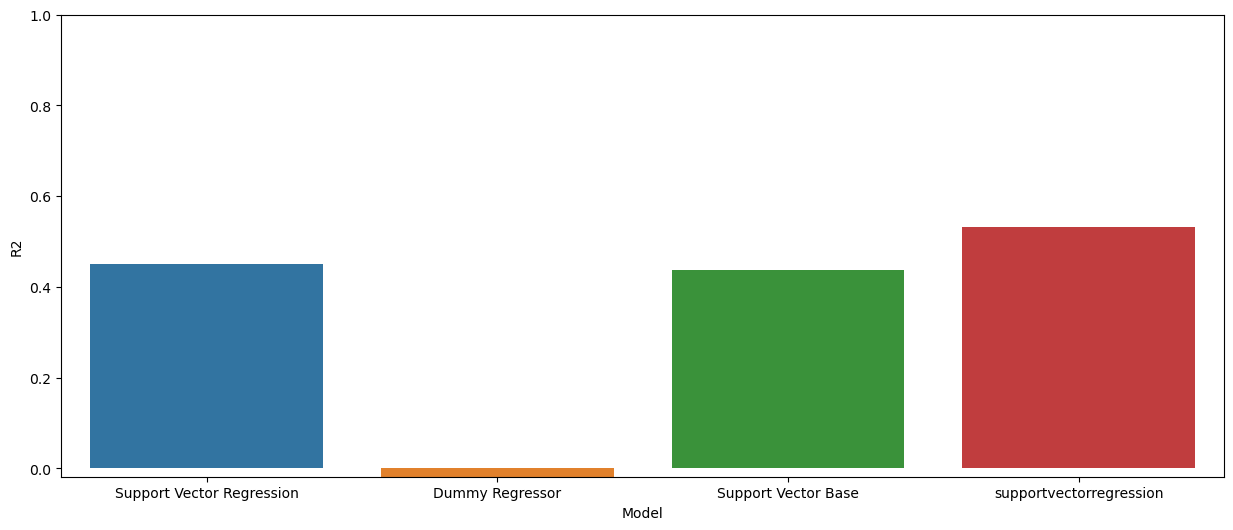

In [ ]:
#plot finalcompare
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_ylim(min(finalcompare['R2']))
sns.barplot(x='Model', y='R2', data=finalcompare)

As i am training many models, i feel that this small comparison to the baseline is not enough to show the effectiveness of the hyperparameter tuning so i will instead use some seaborn visualizations to create some insightful graphs to show the overall increase in performance form hyperparameter tuning


C:\Users\cairu\AppData\Local\Temp\ipykernel_16948\4026401892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseresults['class'] = 'baseline'


<Axes: xlabel='class', ylabel='R2'>

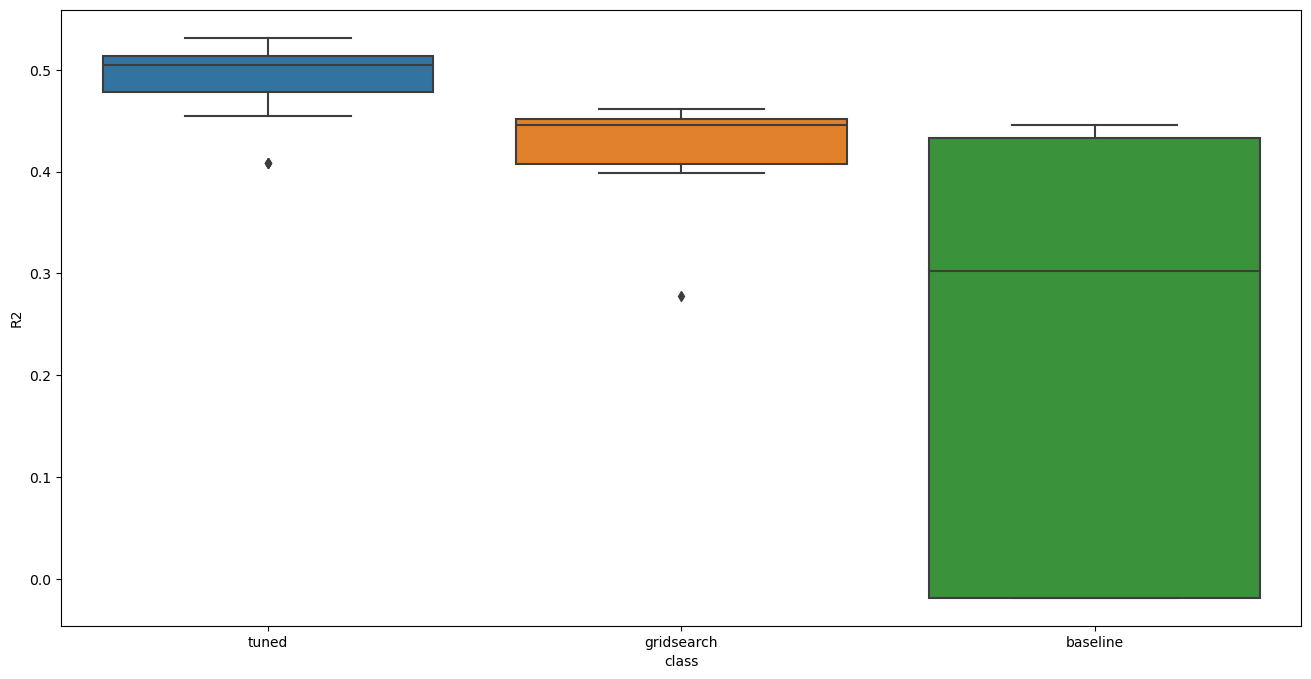

In [ ]:
#plot box plots, 1 for baseline, 1 for tuned, 1 for gridsearch

#combine all and set class column to baseline, tuned, gridsearch
allclass['class'] = 'tuned'
baseresults['class'] = 'baseline'
gridsearched['class'] = 'gridsearch'


allclass = pd.concat([allclass, gridsearched, baseresults], ignore_index=True)

#boxplots
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x='class', y='R2', data=allclass, ax=ax)


### box plot evaluation


To evaluate the quality of a system, we consider several factors, including performance, consistency, and variability. In the context of the box plot analysis:

Performance: 

    The median value of the "tuned" class is higher than that of the other classes. This indicates that the tuned models generally achieve better results in terms of the R2 metric. A higher median suggests a higher average performance, which is an important aspect of evaluating system quality.

Consistency: 

    The interquartile range (IQR) of the "tuned" class is relatively narrow compared to the other classes. This indicates that the tuned models consistently perform well, with less variability in their results. A narrow IQR suggests that the models in the tuned class consistently produce R2 values within a relatively narrow range, indicating a more stable and consistent system.

Variability: 

    The interquartile range (IQR) of the "gridsearch" class is wider than that of the "baseline" class. This suggests that the gridsearch models exhibit more variability in their performance compared to the baseline models. While the median of the "gridsearch" class is higher than that of the "baseline" class, the wider IQR indicates that the gridsearch models have a broader range of R2 values, implying a higher level of variability in their performance.

Based on these observations, it can be concluded that the "tuned" class demonstrates the best overall system quality, with consistently higher performance and less variability. The "gridsearch" class follows, showing relatively higher performance but with more variability. Lastly, the "baseline" class exhibits poorer performance and the least variability among the three classes. Therefore the best system would logically be the best model from the tuned class (SVR from tuned)